In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse,r2_score as r2, mean_absolute_error as mae , make_scorer 
import sklearn.preprocessing as pre
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
#Linear Models
import sklearn.linear_model as lm
#Trees - Non-Linear
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.ensemble import AdaBoostRegressor as ada

#NeuralNet - Piecewise Linear
from sklearn.neural_network import MLPRegressor as fnn

from main import RollingWindowSplit

### Estimate Model and Store Results

In [2]:
feature_set = [[32,53,'vix20',21],[22,63,'vix40',41],[12,73,'vix60',61],[2,83,'vix80',81]]
naif = {81:0.05,61:0.08,41:0.11,21:0.15}
purge = 5
alpha1 = 1
alpha2 = 1

In [10]:
def regression_test(path,intercept=True,pre_train=1000):
    result1 = pd.DataFrame(columns=['VIX2','VIX_Naif','VIX*2','Linear','Ridge','Lasso','Elastic','Huber','RF','FNN'],index=[21,41,61,81])
    result2 = pd.DataFrame(columns=['VIX2','VIX_Naif','VIX*2','Linear','Ridge','Lasso','Elastic','Huber','RF','FNN'],index=[21,41,61,81])
    surface = pd.read_csv(path)
    
    
    #Restrict database in order to eliminate some outliers concentrated before 2000   940:
    surface = surface.loc[940:]
    surface.reset_index(inplace=True) #Need to reset index cause after slicing index start from 940 and .loc wrongly indenty it
    surface.drop(columns='level_0',inplace=True)

    '''LINEAR REGRESSION'''
    
    for fset in feature_set:
        feature_start , feature_end , vix_code, result_index = fset
        avg_w1 = []
        w_count1 = []
        avg_w2 = []
        w_count2 = []
        time = []
        Y1_true = []
        Y1_hat  = []
        Y2_true = []
        Y2_hat  = []


        for i,j in RollingWindowSplit().split_bounds(surface,pre_train,30, purge=purge):
            train_start, train_end = i[0], i[1]
            test_start, test_end = j[0], j[1]
            #Split Train Set
            X80_train = surface.iloc[train_start:train_end,range(feature_start,feature_end,1)].values

            Y1_train= surface.loc[train_start:train_end-1,'var30'].values   

            VIX_train = surface.loc[train_start:train_end-1,vix_code].values
            Y2_80_train= surface.loc[train_start:train_end-1,'var30'].values - VIX_train
            #We used train_end -1 because .loc() is inclusive of the up bound contrary to .iloc() or range()


            #Split Test Set
            X80_test = surface.iloc[test_start:test_end,range(feature_start,feature_end,1)].values

            Y1_test= surface.loc[test_start:test_end-1,'var30'].values

            VIX_test = surface.loc[test_start:test_end-1,vix_code].values
            Y2_80_test= surface.loc[test_start:test_end-1,'var30'].values - VIX_test



            '''REGRESSION 1'''
            #Intialize Linear Regressor
            regressor1 = lm.LinearRegression(fit_intercept=intercept)

            #Fit the Linear Regressor
            regressor1.fit(X80_train,Y1_train)

            #Predict OOS
            Y1_true.extend(Y1_test)
            Y1_hat.extend(regressor1.predict(X80_test))


            '''REGRESSION 2'''
            #Intialize Linear Regressor
            regressor2 = lm.LinearRegression(fit_intercept=intercept)

            #Fit the Linear Regressor
            regressor2.fit(X80_train,Y2_80_train)

            #Predict OOS
            Y2_true.extend(Y2_80_test  +  VIX_test)
            Y2_hat.extend(regressor2.predict(X80_test) + VIX_test)
            
            #Storing Coefficients
            avg_w1.append(regressor1.coef_.mean())
            w_count1.append(np.count_nonzero(regressor1.coef_))
            
            avg_w2.append(regressor2.coef_.mean())
            w_count2.append(np.count_nonzero(regressor2.coef_))
            
            time.append(test_end)

        #Store results in the Results Dataframe
        result1.loc[result_index,'Linear'] = r2(Y1_true,Y1_hat)
        result2.loc[result_index,'Linear'] = r2(Y2_true,Y2_hat)
        
        #Store Collected Coefficients
        weight_count_Linear1 = w_count1
        avg_weight_Linear1 = avg_w1
        weight_count_Linear2 = w_count2
        avg_weight_Linear2 = avg_w2
        
        #Retrieve the timestamps 
        time = np.array(time)
        time = time
        timestamps = surface.loc[time]['date'].values
        


    '''RIDGE REGRESSION'''

    
    for fset in feature_set:
        feature_start , feature_end , vix_code, result_index = fset
        Y1_true = []
        Y1_hat  = []
        Y2_true = []
        Y2_hat  = []
        avg_w1 = []
        w_count1 = []
        avg_w2 = []
        w_count2 = []
        ridge_coef1 = []
        ridge_coef2 = []


        for i,j in RollingWindowSplit().split_bounds(surface,pre_train,30,purge=purge):
            train_start, train_end = i[0], i[1]
            test_start, test_end = j[0], j[1]
            #Split Train Set
            X80_train = surface.iloc[train_start:train_end,range(feature_start,feature_end,1)].values
            Y1_train= surface.loc[train_start:train_end-1,'var30'].values 
            VIX_train = surface.loc[train_start:train_end-1,vix_code].values
            Y2_80_train= surface.loc[train_start:train_end-1,'var30'].values - VIX_train
            #We used train_end -1 because .loc() is inclusive of the up bound contrary to .iloc() or range()


            #Split Test Set
            X80_test = surface.iloc[test_start:test_end,range(feature_start,feature_end,1)].values
            Y1_test= surface.loc[test_start:test_end-1,'var30'].values
            VIX_test = surface.loc[test_start:test_end-1,vix_code].values
            Y2_80_test= surface.loc[test_start:test_end-1,'var30'].values - VIX_test



            '''REGRESSION 1'''
            #Intialize Ridge Regressor
            regressor1 = lm.Ridge(alpha=10000,fit_intercept=intercept,max_iter=2000)

            #Fit the Ridge Regressor
            regressor1.fit(X80_train,Y1_train)

            #Predict OOS
            Y1_true.extend(Y1_test)
            Y1_hat.extend(regressor1.predict(X80_test))


            '''REGRESSION 2'''
            #Intialize Ridge Regressor
            regressor2 = lm.Ridge(alpha=10000,fit_intercept=intercept,max_iter=2000)

            #Fit the Ridge Regressor
            regressor2.fit(X80_train,Y2_80_train)

            #Predict OOS
            Y2_true.extend(Y2_80_test  +  VIX_test)
            Y2_hat.extend(regressor2.predict(X80_test) +  VIX_test)
            
            #Storing Coefficients
            avg_w1.append(regressor1.coef_.mean())
            w_count1.append(np.count_nonzero(regressor1.coef_))
            
            avg_w2.append(regressor2.coef_.mean())
            w_count2.append(np.count_nonzero(regressor2.coef_))
            
            #Collect the weights Ridge regressions
            ridge_coef1.append(regressor1.coef_)
            ridge_coef2.append(regressor2.coef_)

        result1.loc[result_index,'Ridge'] = r2(Y1_true,Y1_hat)
        result2.loc[result_index,'Ridge'] = r2(Y2_true,Y2_hat)
        
        #Store Collected Coefficients
        weight_count_Ridge1 = w_count1
        avg_weight_Ridge1 = avg_w1
        weight_count_Ridge2 = w_count2
        avg_weight_Ridge2 = avg_w2
  

    '''VIX80'''

    for fset in feature_set:
        feature_start , feature_end , vix_code, result_index = fset
        Y1_true = []
        Y1_hat  = []
        Y2_true = []
        Y2_hat  = []


        for i,j in RollingWindowSplit().split_bounds(surface,pre_train,30, purge=purge):
            train_start, train_end = i[0], i[1]
            test_start, test_end = j[0], j[1]
            #Split Train Set
            X80_train = surface.iloc[train_start:train_end,range(feature_start,feature_end,1)].values
            Y1_train= surface.loc[train_start:train_end-1,'var30'].values   
            VIX_train = surface.loc[train_start:train_end-1,vix_code].values
            Y2_80_train= surface.loc[train_start:train_end-1,'var30'].values - VIX_train
            #We used train_end -1 because .loc() is inclusive of the up bound contrary to .iloc() or range()


            #Split Test Set
            X80_test = surface.iloc[test_start:test_end,range(feature_start,feature_end,1)].values
            Y1_test= surface.loc[test_start:test_end-1,'var30'].values
            VIX_test = surface.loc[test_start:test_end-1,vix_code].values
            Y2_80_test= surface.loc[test_start:test_end-1,'var30'].values - VIX_test



            '''REGRESSION 1'''
            #Intialize VIX Regressor
            #regressor1 = lm.LinearRegression()

            #Predict OOS
            Y1_true.extend(Y1_test)
            Y1_hat.extend(VIX_test)


            '''REGRESSION 2'''
            #Intialize VIX Regressor
            #regressor2 = lm.LinearRegression()

            #Predict OOS
            Y2_true.extend(Y2_80_test  +  VIX_test)
            Y2_hat.extend(VIX_test)

        #Store results in the Results Dataframe
        result1.loc[result_index,'VIX*2'] = r2(Y1_true,Y1_hat)
        result2.loc[result_index,'VIX*2'] = r2(Y2_true,Y2_hat)

    '''VIX Naif'''


    for fset in feature_set:
        feature_start , feature_end , vix_code, result_index = fset
        Y1_true = []
        Y1_hat  = []
        Y2_true = []
        Y2_hat  = []


        for i,j in RollingWindowSplit().split_bounds(surface,pre_train,30, purge=purge):
            train_start, train_end = i[0], i[1]
            test_start, test_end = j[0], j[1]
            #Split Train Set
            X80_train = surface.iloc[train_start:train_end,range(feature_start,feature_end,1)].values
            Y1_train= surface.loc[train_start:train_end-1,'var30'].values   
            VIX_train = surface.loc[train_start:train_end-1,vix_code].values 
            Y2_80_train= surface.loc[train_start:train_end-1,'var30'].values - VIX_train
            #We used train_end -1 because .loc() is inclusive of the up bound contrary to .iloc() or range()


            #Split Test Set
            X80_test = surface.iloc[test_start:test_end,range(feature_start,feature_end,1)].values
            Y1_test= surface.loc[test_start:test_end-1,'var30'].values
            VIX_test = surface.loc[test_start:test_end-1,vix_code].values
            Y2_80_test= surface.loc[test_start:test_end-1,'var30'].values - VIX_test



            '''REGRESSION 1'''
            #Intialize VIX Regressor
            #regressor1 = lm.LinearRegression()

            #Predict OOS
            Y1_true.extend(Y1_test)
            Y1_hat.extend(VIX_test*(1+naif[result_index]))


            '''REGRESSION 2'''
            #Intialize VIX Regressor
            #regressor2 = lm.LinearRegression()

            #Predict OOS
            Y2_true.extend(Y2_80_test  +  VIX_test)
            Y2_hat.extend(VIX_test*(1+naif[result_index]))

        #Store results in the Results Dataframe
        result1.loc[result_index,'VIX_Naif'] = r2(Y1_true,Y1_hat)
        result2.loc[result_index,'VIX_Naif'] = r2(Y2_true,Y2_hat)
        


    '''HUBER REGRESSION'''

    

    for fset in feature_set:
        feature_start , feature_end , vix_code, result_index = fset
        avg_w1 = []
        w_count1 = []
        avg_w2 = []
        w_count2 = []
        Y1_true = []
        Y1_hat  = []
        Y2_true = []
        Y2_hat  = []

        for i,j in RollingWindowSplit().split_bounds(surface,pre_train,30, purge=purge):
            train_start, train_end = i[0], i[1]
            test_start, test_end = j[0], j[1]
            #Split Train Set
            X80_train = surface.iloc[train_start:train_end,range(feature_start,feature_end,1)].values
            Y1_train= surface.loc[train_start:train_end-1,'var30'].values   
            VIX_train = surface.loc[train_start:train_end-1,vix_code].values
            Y2_80_train= surface.loc[train_start:train_end-1,'var30'].values - VIX_train
            #We used train_end -1 because .loc() is inclusive of the up bound contrary to .iloc() or range()


            #Split Test Set
            X80_test = surface.iloc[test_start:test_end,range(feature_start,feature_end,1)].values
            Y1_test= surface.loc[test_start:test_end-1,'var30'].values
            VIX_test = surface.loc[test_start:test_end-1,vix_code].values
            Y2_80_test= surface.loc[test_start:test_end-1,'var30'].values - VIX_test



            '''REGRESSION 1'''
            #Intialize Huber Regressor
            regressor1 = lm.HuberRegressor(alpha=10000,fit_intercept=intercept,max_iter=400)

            #Fit the Huber Regressor
            regressor1.fit(X80_train,Y1_train)

            #Predict OOS
            Y1_true.extend(Y1_test)
            Y1_hat.extend(regressor1.predict(X80_test))


            '''REGRESSION 2'''
            #Intialize Huber Regressor
            regressor2 = lm.HuberRegressor(alpha=10000,fit_intercept=intercept,max_iter=400)

            #Fit the Huber Regressor
            regressor2.fit(X80_train,Y2_80_train)

            #Predict OOS
            Y2_true.extend(Y2_80_test  +  VIX_test)
            Y2_hat.extend(regressor2.predict(X80_test) +  VIX_test)
            
            #Storing Coefficients
            avg_w1.append(regressor1.coef_.mean())
            w_count1.append(np.count_nonzero(regressor1.coef_))
            
            avg_w2.append(regressor2.coef_.mean())
            w_count2.append(np.count_nonzero(regressor2.coef_))
        
        result1.loc[result_index,'Huber'] = r2(Y1_true,Y1_hat)
        result2.loc[result_index,'Huber'] = r2(Y2_true,Y2_hat)
        
        #Store Collected Coefficients
        weight_count_Huber1 = w_count1
        avg_weight_Huber1 = avg_w1
        weight_count_Huber2 = w_count2
        avg_weight_Huber2 = avg_w2
       

    '''LASSO REGRESSION'''


    for fset in feature_set:
        feature_start , feature_end , vix_code, result_index = fset
        Y1_true = []
        Y1_hat  = []
        Y2_true = []
        Y2_hat  = []
        avg_w1 = []
        w_count1 = []
        avg_w2 = []
        w_count2 = []
        lasso_coef1 = []
        lasso_coef2 = []
        lasso_intercept1 = []
        lasso_intercept2 = []
        
        for i,j in RollingWindowSplit().split_bounds(surface,pre_train,30,purge=purge):
            train_start, train_end = i[0], i[1]
            test_start, test_end = j[0], j[1]
            #Split Train Set
            X80_train = surface.iloc[train_start:train_end,range(feature_start,feature_end,1)].values
            Y1_train= surface.loc[train_start:train_end-1,'var30'].values 
            VIX_train = surface.loc[train_start:train_end-1,vix_code].values
            Y2_80_train= surface.loc[train_start:train_end-1,'var30'].values - VIX_train
            #We used train_end -1 because .loc() is inclusive of the up bound contrary to .iloc() or range()


            #Split Test Set
            X80_test = surface.iloc[test_start:test_end,range(feature_start,feature_end,1)].values
            Y1_test= surface.loc[test_start:test_end-1,'var30'].values
            VIX_test = surface.loc[test_start:test_end-1,vix_code].values
            Y2_80_test= surface.loc[test_start:test_end-1,'var30'].values - VIX_test



            '''REGRESSION 1'''
            #Intialize Lasso Regressor
            regressor1 = lm.Lasso(alpha=0.0001,fit_intercept=intercept,max_iter=2000)

            #Fit the Lasso Regressor
            regressor1.fit(X80_train,Y1_train)

            #Predict OOS
            Y1_true.extend(Y1_test)
            Y1_hat.extend(regressor1.predict(X80_test))


            '''REGRESSION 2'''
            #Intialize Lasso Regressor
            regressor2 = lm.Lasso(alpha=0.0001,fit_intercept=intercept,max_iter=2000)

            #Fit the Lasso Regressor
            regressor2.fit(X80_train,Y2_80_train)

            #Predict OOS
            Y2_true.extend(Y2_80_test  +  VIX_test)
            Y2_hat.extend(regressor2.predict(X80_test) +  VIX_test)
            
            #Storing Coefficients
            avg_w1.append(regressor1.coef_.mean())
            w_count1.append(np.count_nonzero(regressor1.coef_))
            
            avg_w2.append(regressor2.coef_.mean())
            w_count2.append(np.count_nonzero(regressor2.coef_))
            
            #Collect the weights in Lasso regressions
            lasso_coef1.append(regressor1.coef_)
            lasso_coef2.append(regressor2.coef_)
            lasso_intercept1.append(regressor1.intercept_)
            lasso_intercept2.append(regressor1.intercept_)
            
        result1.loc[result_index,'Lasso'] = r2(Y1_true,Y1_hat)
        result2.loc[result_index,'Lasso'] = r2(Y2_true,Y2_hat)
        
        #Store Collected Coefficients
        weight_count_Lasso1 = w_count1
        avg_weight_Lasso1 = avg_w1
        weight_count_Lasso2 = w_count2
        avg_weight_Lasso2 = avg_w2
        
        
        

    '''ELASTIC NET'''

    for fset in feature_set:
        feature_start , feature_end , vix_code, result_index = fset
        avg_w1 = []
        w_count1 = []
        avg_w2 = []
        w_count2 = []
        Y1_true = []
        Y1_hat  = []
        Y2_true = []
        Y2_hat  = []


        for i,j in RollingWindowSplit().split_bounds(surface,pre_train,30,purge=purge):
            train_start, train_end = i[0], i[1]
            test_start, test_end = j[0], j[1]
            #Split Train Set
            X80_train = surface.iloc[train_start:train_end,range(feature_start,feature_end,1)].values
            Y1_train= surface.loc[train_start:train_end-1,'var30'].values 
            VIX_train = surface.loc[train_start:train_end-1,vix_code].values
            Y2_80_train= surface.loc[train_start:train_end-1,'var30'].values - VIX_train
            #We used train_end -1 because .loc() is inclusive of the up bound contrary to .iloc() or range()


            #Split Test Set
            X80_test = surface.iloc[test_start:test_end,range(feature_start,feature_end,1)].values
            Y1_test= surface.loc[test_start:test_end-1,'var30'].values
            VIX_test = surface.loc[test_start:test_end-1,vix_code].values
            Y2_80_test= surface.loc[test_start:test_end-1,'var30'].values - VIX_test



            '''REGRESSION 1'''
            #Intialize Elastic Regressor
            regressor1 = lm.ElasticNet(alpha=0.0001,fit_intercept=intercept,max_iter=2000)

            #Fit the Elastic Regressor
            regressor1.fit(X80_train,Y1_train)

            #Predict OOS
            Y1_true.extend(Y1_test)
            Y1_hat.extend(regressor1.predict(X80_test))


            '''REGRESSION 2'''
            #Intialize Elastic Regressor
            regressor2 = lm.ElasticNet(alpha=0.01,fit_intercept=intercept,max_iter=2000)

            #Fit the Elastic Regressor
            regressor2.fit(X80_train,Y2_80_train)

            #Predict OOS
            Y2_true.extend(Y2_80_test  +  VIX_test)
            Y2_hat.extend(regressor2.predict(X80_test) +  VIX_test)
            
            avg_w1.append(regressor1.coef_.mean())
            w_count1.append(np.count_nonzero(regressor1.coef_))
            
            avg_w2.append(regressor2.coef_.mean())
            w_count2.append(np.count_nonzero(regressor2.coef_))
            
        result1.loc[result_index,'Elastic'] = r2(Y1_true,Y1_hat)
        result2.loc[result_index,'Elastic'] = r2(Y2_true,Y2_hat)
    
        
        #Store Collected Coefficients
        weight_count_Elastic1 = w_count1
        avg_weight_Elastic1 = avg_w1
        
        weight_count_Elastic2 = w_count2
        avg_weight_Elastic2 = avg_w2
        
        
    '''FEED-FORWARD NEURAL NET REGRESSION'''

    for fset in feature_set:
        feature_start , feature_end , vix_code, result_index = fset
        Y1_true = []
        Y1_hat  = []
        Y2_true = []
        Y2_hat  = []


        for i,j in RollingWindowSplit().split_bounds(surface,pre_train,30, purge=purge):
            train_start, train_end = i[0], i[1]
            test_start, test_end = j[0], j[1]
            #Split Train Set
            X80_train = surface.iloc[train_start:train_end,range(feature_start,feature_end,1)].values
            Y1_train= surface.loc[train_start:train_end-1,'var30'].values   
            VIX_train = surface.loc[train_start:train_end-1,vix_code].values
            Y2_80_train= surface.loc[train_start:train_end-1,'var30'].values - VIX_train
            #We used train_end -1 because .loc() is inclusive of the up bound contrary to .iloc() or range()


            #Split Test Set
            X80_test = surface.iloc[test_start:test_end,range(feature_start,feature_end,1)].values
            Y1_test= surface.loc[test_start:test_end-1,'var30'].values
            VIX_test = surface.loc[test_start:test_end-1,vix_code].values
            Y2_80_test= surface.loc[test_start:test_end-1,'var30'].values - VIX_test



            '''REGRESSION 1'''
            #Intialize FNN Regressor
            regressor1 = fnn(hidden_layer_sizes=(result_index,),alpha=3000,max_iter=2000,early_stopping=False,shuffle=False,verbose=False)

            #Fit the FNN Regressor
            regressor1.fit(X80_train,Y1_train)

            #Predict OOS
            Y1_true.extend(Y1_test)
            Y1_hat.extend(regressor1.predict(X80_test))


            '''REGRESSION 2'''
            #Intialize FNN Regressor
            regressor2 = fnn(hidden_layer_sizes=(result_index,),alpha=1000,max_iter=2000,early_stopping=False,shuffle=False,verbose=False)

            #Fit the FNN Regressor
            regressor2.fit(X80_train,Y2_80_train)

            #Predict OOS
            Y2_true.extend(Y2_80_test  +  VIX_test)
            Y2_hat.extend(regressor2.predict(X80_test) +  VIX_test)

        result1.loc[result_index,'FNN'] = r2(Y1_true,Y1_hat)
        result2.loc[result_index,'FNN'] = r2(Y2_true,Y2_hat)


    '''RF REGRESSION'''


    for fset in feature_set:
        feature_start , feature_end , vix_code, result_index = fset
        Y1_true = []
        Y1_hat  = []
        Y2_true = []
        Y2_hat  = []


        for i,j in RollingWindowSplit().split_bounds(surface,pre_train,30, purge=purge):
            train_start, train_end = i[0], i[1]
            test_start, test_end = j[0], j[1]
            #Split Train Set
            X80_train = surface.iloc[train_start:train_end,range(feature_start,feature_end,1)].values
            Y1_train= surface.loc[train_start:train_end-1,'var30'].values   
            VIX_train = surface.loc[train_start:train_end-1,vix_code].values
            Y2_80_train= surface.loc[train_start:train_end-1,'var30'].values - VIX_train
            #We used train_end -1 because .loc() is inclusive of the up bound contrary to .iloc() or range()


            #Split Test Set
            X80_test = surface.iloc[test_start:test_end,range(feature_start,feature_end,1)].values
            Y1_test= surface.loc[test_start:test_end-1,'var30'].values
            VIX_test = surface.loc[test_start:test_end-1,vix_code].values
            Y2_80_test= surface.loc[test_start:test_end-1,'var30'].values - VIX_test



            '''REGRESSION 1'''
            #Intialize FNN Regressor
            regressor1 = rf(max_depth=45,n_estimators=100)

            #Fit the FNN Regressor
            regressor1.fit(X80_train,Y1_train)

            #Predict OOS
            Y1_true.extend(Y1_test)
            Y1_hat.extend(regressor1.predict(X80_test))


            '''REGRESSION 2'''
            #Intialize FNN Regressor
            regressor2 = rf(max_depth=45,n_estimators=100)

            #Fit the FNN Regressor
            regressor2.fit(X80_train,Y2_80_train)

            #Predict OOS
            Y2_true.extend(Y2_80_test  +  VIX_test)
            Y2_hat.extend(regressor2.predict(X80_test) +  VIX_test)

        result1.loc[result_index,'RF'] = r2(Y1_true,Y1_hat)
        result2.loc[result_index,'RF'] = r2(Y2_true,Y2_hat)

         
    #manage time series of coefficients into dataframes
    ridge_coef1 = np.array(ridge_coef1)
    ridge_coef1 = pd.DataFrame(columns=[i for i in range(-200,205,5)],index=timestamps,data=ridge_coef1,dtype=float)
    ridge_coef2 = np.array(ridge_coef2)
    ridge_coef2 = pd.DataFrame(columns=[i for i in range(-200,205,5)],index=timestamps,data=ridge_coef2,dtype=float)

    lasso_coef1 = np.array(lasso_coef1)
    lasso_coef1 = pd.DataFrame(columns=[i for i in range(-200,205,5)],index=timestamps,data=lasso_coef1,dtype=float)
    lasso_coef2 = np.array(lasso_coef2)
    lasso_coef2 = pd.DataFrame(columns=[i for i in range(-200,205,5)],index=timestamps,data=lasso_coef2,dtype=float)      
    lasso_intercept = pd.DataFrame(index=timestamps,data={'Lasso1':lasso_intercept1,'Lasso2':lasso_intercept2})

    #Convert Stored Weights info into Dataframes
    avg_weight1 = pd.DataFrame(index=timestamps,data={'Linear':avg_weight_Linear1,'Ridge':avg_weight_Ridge1,'Lasso':avg_weight_Lasso1,'Huber':avg_weight_Huber1,'Elastic':avg_weight_Elastic1})
    weight_count1 = pd.DataFrame(index=timestamps,data={'Linear':weight_count_Linear1,'Ridge':weight_count_Ridge1,'Lasso':weight_count_Lasso1,'Huber':weight_count_Huber1,'Elastic':weight_count_Elastic1})

    avg_weight2 = pd.DataFrame(index=timestamps,data={'Linear':avg_weight_Linear2,'Ridge':avg_weight_Ridge2,'Lasso':avg_weight_Lasso2,'Huber':avg_weight_Huber2,'Elastic':avg_weight_Elastic2})
    weight_count2 = pd.DataFrame(index=timestamps,data={'Linear':weight_count_Linear2,'Ridge':weight_count_Ridge2,'Lasso':weight_count_Lasso2,'Huber':weight_count_Huber2,'Elastic':weight_count_Elastic2})

    return result1, result2 , avg_weight1, weight_count1, avg_weight2, weight_count2 , lasso_coef1, lasso_coef2 ,lasso_intercept,ridge_coef1,ridge_coef2 

In [11]:
result1, result2 , avg_weight1, weight_count1, avg_weight2, weight_count2 , lasso_coef1, lasso_coef2 ,lasso_intercept,ridge_coef1,ridge_coef2 = regression_test(intercept=True, pre_train=1000, path='/home/student/surface/Realized_Variance/DatasetSPX/Dataset30_withmean.csv')

In [23]:
result1

,VIX2,VIX_Naif,VIX*2,Linear,Ridge,Lasso,Elastic,Huber,RF,FNN
21,NaN,0.20596,0.16263,0.399065,0.328683,0.405026,0.410371,0.39882,0.260187,-0.441721
41,NaN,0.330687,0.296162,0.329917,0.389021,0.399316,0.394084,0.389666,0.265585,-0.364992
61,NaN,0.379101,0.355079,0.290857,0.411097,0.38697,0.371389,0.377438,0.289936,-0.0025925
81,NaN,0.399335,0.385059,0.255122,0.41431,0.386468,0.370635,0.354194,0.262555,-0.144419


In [24]:
result2

,VIX2,VIX_Naif,VIX*2,Linear,Ridge,Lasso,Elastic,Huber,RF,FNN
21,NaN,0.20596,0.16263,0.399065,0.352743,0.403939,0.228661,0.398852,0.261326,-0.202591
41,NaN,0.330687,0.296162,0.329917,0.403126,0.399059,0.320883,0.389668,0.274406,0.143518
61,NaN,0.379101,0.355079,0.290857,0.419163,0.385453,0.367821,0.352159,0.278702,0.201374
81,NaN,0.399335,0.385059,0.255122,0.420321,0.384697,0.39205,0.354313,0.276171,0.455579


In [534]:
result2

,VIX2,VIX_Naif,VIX*2,Linear,Ridge,Lasso,Elastic,Huber,TheilSen,RF,FNN
21,NaN,0.20596,0.16263,0.399065,0.352743,0.403939,0.365854,0.402498,NaN,NaN,NaN
41,NaN,0.330687,0.296162,0.329917,0.403126,0.399059,0.393987,0.374296,NaN,NaN,NaN
61,NaN,0.379101,0.355079,0.290857,0.419163,0.385453,0.403592,0.36241,NaN,NaN,NaN
81,NaN,0.399335,0.385059,0.255122,0.420321,0.384697,0.410707,0.340341,NaN,NaN,NaN


In [535]:
result1

,VIX2,VIX_Naif,VIX*2,Linear,Ridge,Lasso,Elastic,Huber,TheilSen,RF,FNN
21,NaN,0.20596,0.16263,0.399065,0.385659,0.405026,0.372937,0.401387,NaN,NaN,NaN
41,NaN,0.330687,0.296162,0.329917,0.420445,0.399316,0.39328,0.360197,NaN,NaN,NaN
61,NaN,0.379101,0.355079,0.290857,0.399084,0.38697,0.393555,0.34146,NaN,NaN,NaN
81,NaN,0.399335,0.385059,0.255122,0.388984,0.386468,0.393414,0.332011,NaN,NaN,NaN


In [8]:
result2

,VIX2,VIX_Naif,VIX*2,Linear,Ridge,Lasso,Elastic,Huber,RF,FNN
21,NaN,0.200769,0.156165,0.23395,0.303438,0.2672,0.22805,0.394581,-0.0379792,0.17232
41,NaN,0.332282,0.296646,0.0622627,0.308323,0.229352,0.324459,0.342436,0.00866286,0.271238
61,NaN,0.38382,0.359157,-0.120514,0.289743,0.240987,0.372494,0.271001,0.0155598,0.412097
81,NaN,0.40551,0.39094,-0.211748,0.271538,0.227001,0.398009,0.231591,0.0281059,0.389911


In [9]:
result1

,VIX2,VIX_Naif,VIX*2,Linear,Ridge,Lasso,Elastic,Huber,RF,FNN
21,NaN,0.200769,0.156165,0.23395,0.284822,0.277869,0.271165,0.39458,-0.061676,-0.0647292
41,NaN,0.332282,0.296646,0.0622627,0.297066,0.230694,0.235988,0.342457,-0.0456206,-0.0508335
61,NaN,0.38382,0.359157,-0.120514,0.282792,0.228348,0.187586,0.270957,-0.0675202,-0.0600385
81,NaN,0.40551,0.39094,-0.211748,0.267712,0.206402,0.154028,0.231551,-0.0746479,-0.205845


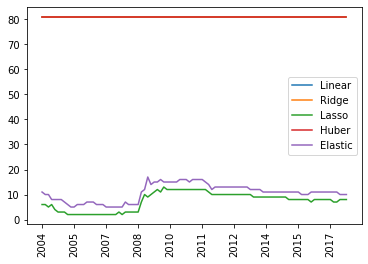

In [25]:
plt.plot(weight_count1.values)
plt.legend(weight_count1.columns)
plt.xticks(ticks=np.arange(0,100,10),labels=np.round(weight_count1.iloc[np.arange(0,100,10),:].index.values[:]/10000).astype(int),rotation=90)
plt.show()

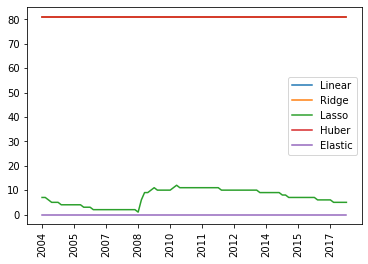

In [26]:
plt.plot(weight_count2.values)
plt.legend(weight_count2.columns)
plt.xticks(ticks=np.arange(0,100,10),labels=np.round(weight_count2.iloc[np.arange(0,100,10),:].index.values[:]/10000).astype(int),rotation=90)
plt.show()

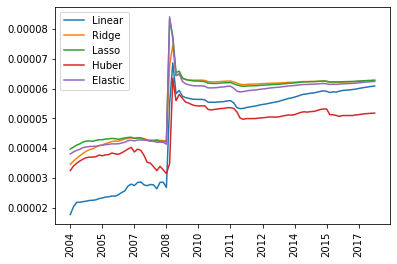

In [27]:
plt.plot(avg_weight1.values)
plt.legend(avg_weight1.columns)
plt.xticks(ticks=np.arange(0,100,10),labels=np.round(avg_weight1.iloc[np.arange(0,100,10),:].index.values[:]/10000).astype(int),rotation=90)
plt.show()

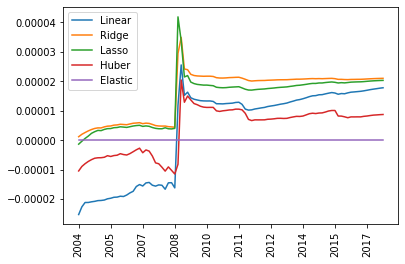

In [28]:
plt.plot(avg_weight2.values)
plt.legend(avg_weight2.columns)
plt.xticks(ticks=np.arange(0,100,10),labels=np.round(avg_weight2.iloc[np.arange(0,100,10),:].index.values[:]/10000).astype(int),rotation=90)
plt.show()

### Analyze the portfolio exposure of Lasso and Ridge model

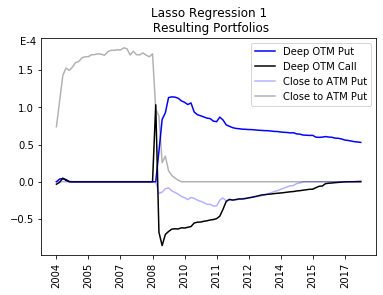

In [29]:
plt.plot(lasso_coef1[[i for i in range(-200,-100,5)]].mean(axis=1).values*10000,c='b')
plt.plot(lasso_coef1[[i for i in range(200,100,-5)]].mean(axis=1).values*10000,c='k')
plt.plot(lasso_coef1[[i for i in range(-50,0,5)]].mean(axis=1).values*10000,c='b',alpha=0.3)
plt.plot(lasso_coef1[[i for i in range(50,0,-5)]].mean(axis=1).values*10000,c='k',alpha=0.3)
plt.legend(['Deep OTM Put','Deep OTM Call','Close to ATM Put','Close to ATM Put'])
plt.annotate('E-4',xy=(20,250),xycoords='figure points')
plt.title('Lasso Regression 1\n Resulting Portfolios')
plt.xticks(ticks=np.arange(0,100,10),labels=np.round(lasso_coef1.iloc[np.arange(0,100,10),:].index.values[:]/10000).astype(int),rotation=90)
plt.show()

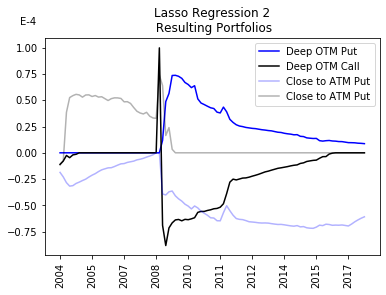

In [30]:
plt.plot(lasso_coef2[[i for i in range(-200,-100,5)]].mean(axis=1).values*10000,c='b')
plt.plot(lasso_coef2[[i for i in range(200,100,-5)]].mean(axis=1).values*10000,c='k')
plt.plot(lasso_coef2[[i for i in range(-50,0,5)]].mean(axis=1).values*10000,c='b',alpha=0.3)
plt.plot(lasso_coef2[[i for i in range(50,0,-5)]].mean(axis=1).values*10000,c='k',alpha=0.3)
plt.legend(['Deep OTM Put','Deep OTM Call','Close to ATM Put','Close to ATM Put'])
plt.annotate('E-4',xy=(20,270),xycoords='figure points')
plt.xticks(ticks=np.arange(0,100,10),labels=np.round(lasso_coef2.iloc[np.arange(0,100,10),:].index.values[:]/10000).astype(int),rotation=90)
plt.title('Lasso Regression 2\n Resulting Portfolios')
plt.show()

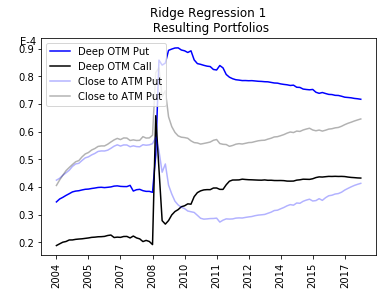

In [31]:
plt.plot(ridge_coef1[[i for i in range(-200,-100,5)]].mean(axis=1).values*10000,c='b')
plt.plot(ridge_coef1[[i for i in range(200,100,-5)]].mean(axis=1).values*10000,c='k')
plt.plot(ridge_coef1[[i for i in range(-50,0,5)]].mean(axis=1).values*10000,c='b',alpha=0.3)
plt.plot(ridge_coef1[[i for i in range(50,0,-5)]].mean(axis=1).values*10000,c='k',alpha=0.3)
plt.legend(['Deep OTM Put','Deep OTM Call','Close to ATM Put','Close to ATM Put'])
plt.annotate('E-4',xy=(20,250),xycoords='figure points')
plt.title('Ridge Regression 1\n Resulting Portfolios')
plt.xticks(ticks=np.arange(0,100,10),labels=np.round(ridge_coef1.iloc[np.arange(0,100,10),:].index.values[:]/10000).astype(int),rotation=90)
plt.show()

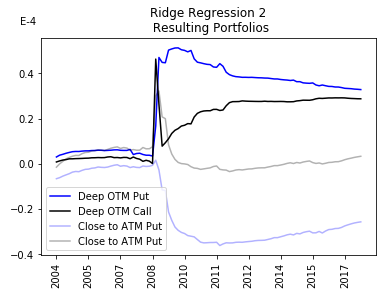

In [32]:
plt.plot(ridge_coef2[[i for i in range(-200,-100,5)]].mean(axis=1).values*10000,c='b')
plt.plot(ridge_coef2[[i for i in range(200,100,-5)]].mean(axis=1).values*10000,c='k')
plt.plot(ridge_coef2[[i for i in range(-50,0,5)]].mean(axis=1).values*10000,c='b',alpha=0.3)
plt.plot(ridge_coef2[[i for i in range(50,0,-5)]].mean(axis=1).values*10000,c='k',alpha=0.3)
plt.legend(['Deep OTM Put','Deep OTM Call','Close to ATM Put','Close to ATM Put'])
plt.annotate('E-4',xy=(20,270),xycoords='figure points')
plt.xticks(ticks=np.arange(0,100,10),labels=np.round(ridge_coef2.iloc[np.arange(0,100,10),:].index.values[:]/10000).astype(int),rotation=90)
plt.title('Ridge Regression 2\n Resulting Portfolios')
plt.show()

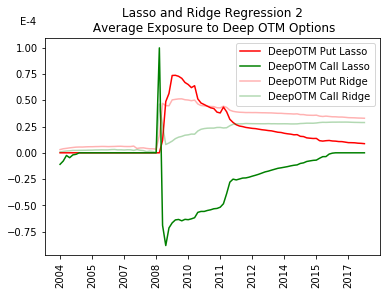

In [33]:
plt.plot(lasso_coef2[[i for i in range(-200,-100,5)]].mean(axis=1).values*10000,c='r')
plt.plot(lasso_coef2[[i for i in range(200,100,-5)]].mean(axis=1).values*10000,c='g')
plt.plot(ridge_coef2[[i for i in range(-200,-100,5)]].mean(axis=1).values*10000,c='r',alpha=0.3)
plt.plot(ridge_coef2[[i for i in range(200,100,-5)]].mean(axis=1).values*10000,c='g',alpha=0.3)
plt.legend(['DeepOTM Put Lasso','DeepOTM Call Lasso','DeepOTM Put Ridge','DeepOTM Call Ridge'])
plt.annotate('E-4',xy=(20,270),xycoords='figure points')
plt.xticks(ticks=np.arange(0,100,10),labels=np.round(ridge_coef2.iloc[np.arange(0,100,10),:].index.values[:]/10000).astype(int),rotation=90)
plt.title('Lasso and Ridge Regression 2\n Average Exposure to Deep OTM Options')
plt.show()

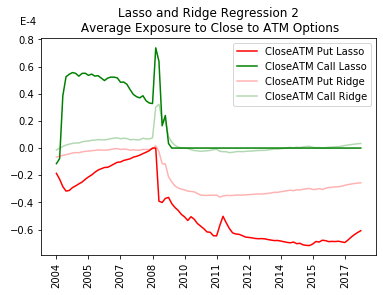

In [34]:
plt.plot(lasso_coef2[[i for i in range(-50,0,5)]].mean(axis=1).values*10000,c='r')
plt.plot(lasso_coef2[[i for i in range(50,0,-5)]].mean(axis=1).values*10000,c='g')
plt.plot(ridge_coef2[[i for i in range(-50,0,5)]].mean(axis=1).values*10000,c='r',alpha=0.3)
plt.plot(ridge_coef2[[i for i in range(50,0,-5)]].mean(axis=1).values*10000,c='g',alpha=0.3)
plt.legend(['CloseATM Put Lasso','CloseATM Call Lasso','CloseATM Put Ridge','CloseATM Call Ridge'])
plt.annotate('E-4',xy=(20,270),xycoords='figure points')
plt.xticks(ticks=np.arange(0,100,10),labels=np.round(ridge_coef2.iloc[np.arange(0,100,10),:].index.values[:]/10000).astype(int),rotation=90)
plt.title('Lasso and Ridge Regression 2\n Average Exposure to Close to ATM Options')
plt.show()

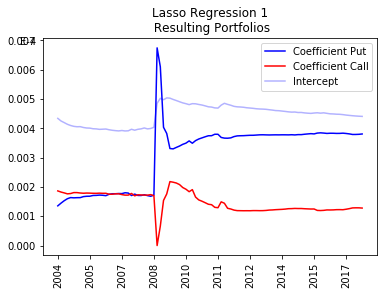

In [35]:
plt.plot(lasso_coef1[[i for i in range(200,0,-5)]].sum(axis=1).values,c='b')
plt.plot(lasso_coef1[[i for i in range(-200,0,5)]].sum(axis=1).values,c='r')
plt.plot(lasso_intercept.Lasso1.values,c='b',alpha=0.3)
plt.legend(['Coefficient Put','Coefficient Call','Intercept'])
plt.annotate('E-4',xy=(20,250),xycoords='figure points')
plt.title('Lasso Regression 1\n Resulting Portfolios')
plt.xticks(ticks=np.arange(0,100,10),labels=np.round(lasso_coef1.iloc[np.arange(0,100,10),:].index.values[:]/10000).astype(int),rotation=90)
plt.show()